This demo is implemented by Python with XGBoost and PyTorch

# Pre-setting

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from itertools import chain
import pandas as pd
from pandas import Series, DataFrame
import re
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import gc

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
!pip install torchtext==0.5.0

In [0]:
save_path = "drive/My Drive/Master CoureWork/IRDM/"
train_data_path = save_path+"part2/train_data.tsv"
validation_data_path = save_path+"part2/validation_data.tsv"

In [0]:
stopwords_ = stopwords.words('english')
# add 'white space' stopwords list
stopwords_.append(' ') 

#---

#Model BM25#



##Text Statistics#

**Pre-processing**

In [0]:
def text_processing(passage, stopwords_):
  """
  This part is to pre-processing the text information
  """
  # convert text to lower-case
  passage = passage.lower()
  # get rid of not common punctuations; including '•!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’'
  passage = re.sub(r'[^a-zA-Z0-9]', ' ', passage)  #passage.translate(str.maketrans({key:' ' for key in string.punctuation+"•"+"’"}))
  # tokenization
  passage = passage.split()
  tokens = []
  for key in passage:
    # lemmatization
    key = lemmatizer.lemmatize(key, pos = 'v')
    # stemming
    key = SnowballStemmer("english").stem(key)
    # stopwords/number removal
    if key not in stopwords_:
      tokens.append(key)

  return tokens

In [0]:
candidate_passage = pd.read_csv(validation_data_path, sep='\t')

In [0]:
def inverted_indx(indx):
  """
  Inverted index function
  Output: PID, frequency, position, passage length/average length
  """
  # extract all information corresponding to the selected qid
  top1000 = candidate_passage.loc[(candidate_passage["qid"] == indx)]
  pid_total = top1000.iloc[:, 1]

  len_item = []
  words_number = {}
  pid_pos = {}
  word_pos = {}
  for n_string in range(len(top1000)):
    # extract each pair of pid and text
    string_ = text_processing(top1000.iloc[n_string, 3], stopwords_)
    pid  = top1000.iloc[n_string, 1]
    # length of each passage
    len_item.append(len(string_))
    # calculate posting of [PID, frequency], [PID, positions]
    for n in range(len(string_)):
      
      if string_[n] in words_number.keys() and words_number[string_[n]][-1][0] == pid:
        words_number[string_[n]][-1] = [pid, words_number[string_[n]][-1][1]+1]
        pid_pos[string_[n]][-1].append(n+1)

      elif string_[n] in words_number.keys() and words_number[string_[n]][-1][0] != pid: 
        words_number[string_[n]].append([pid, 1])
        pid_pos[string_[n]].append([pid, n+1])

      else:
        words_number[string_[n]] = [[pid, 1]]
        pid_pos[string_[n]] = [[pid, n+1]]
  # (lenth/average length) for BM25
  len_average = np.array(len_item)/(np.sum(np.array(len_item))/len(len_item))

  return [words_number, pid_pos, pid_total, len_average]


In [0]:
"""
query_inverted_indx -> dictionary format: {qid: [pid, words number], [pid, position], pid, individual document length/document average length}
"""
# extract all QID
qid_s = np.unique(candidate_passage.iloc[:, 0].to_numpy())
# calculate inverted index of frequency and positions for each query
query_inverted_indx = {}
for qid in qid_s:
  query_inverted_indx[qid] = inverted_indx(qid)

##Basic Retrieval Models#

**BM25**

In [0]:
def BM25(indx, query_full, pid, data, N, R, b, k_1, k_2, len_average, top100, relevance):
  """"
  BM25 Model
  Input: QID, query, PID, passages, parameters, document length/average length
  Output: write the output to file_BM25
  """
  # extract query terms
  query = list(set(query_full))

  n_collection = np.zeros((1, len(query)))
  n_document = np.zeros((len(query)+1, len(pid)))
  n_document[0,:] = pid
  
  for i in range(len(query)):
    if query[i] not in data.keys():
      continue 
    else:
      # the number that word i occuring in the collection
      n_collection[0, i] = len(data[query[i]])

      # the number that word i occuring in each document
      pid_word = np.array(data[query[i]])[:,0]
      num_word = np.array(data[query[i]])[:,1]

      for j in range(len(pid_word)):
        loc = np.where(pid == pid_word[j])
        n_document[i+1, loc] = num_word[j]
  # query term frequency
  qf = np.zeros((1,len(query)))
  for n_item in range(len(query)):
    qf[0, n_item] = query_full.count(query[n_item])
  # other parameters derivation
  r = np.zeros((1, len(query)))
  K = k_1*((1-b) + b*len_average)
  n_document = n_document[1:, :]
  # score calculation
  score_1 = np.log(((r+0.5)/(R-r+0.5))/((n_collection-r+0.5)/(N-n_collection-R+r+0.5))) 
  score_2 = n_document*(k_1+1)/(K+n_document)*((k_2+1)*qf/(k_2+qf)).T
  score = score_1 @ score_2
  
  rank = np.squeeze(np.argsort(score))[::-1]

  if len(pid)<top100:
    return relevance[rank[np.arange(len(pid))]]
  else:
    return relevance[rank[np.arange(top100)]]
  

**Output of ranking for both method and BM25**

In [0]:
# QID extraction
qid_s = np.unique(candidate_passage.iloc[:, 0].to_numpy())
top100 = 100
r = {}
n = 0
for indx in qid_s[1:]:
  relevance=[]
  # passages extraction
  data = query_inverted_indx[indx][0].copy()
  pid = query_inverted_indx[indx][2].copy().to_numpy()
  # pre-processing query
  query = text_processing(candidate_passage.loc[(candidate_passage["qid"] == indx)].iloc[0,2], stopwords_)
  relevance = candidate_passage.loc[(candidate_passage["qid"] == indx)].iloc[:, 4].to_numpy()
  ### BM25 ###
  # parameter setting
  N = len(pid)
  R = 0
  b = 0.75
  k_1 = 1.2
  k_2 = 100
  len_average = query_inverted_indx[indx][3]
  # relevance
  r[indx] = BM25(indx, query, pid, data, N, R, b, k_1, k_2, len_average, top100, relevance)


##Model Evaluation#

**Average precision**

In [0]:
def average_precision(r):
  score = 0
  for key in r.keys():
    r_docs = r[key].sum()
    
    if r_docs == 0:
      pass
    else:
      order = np.arange(1, r_docs+1)
      value = (np.array(np.where(r[key] == 1)).squeeze())
      score = score+(order/((value+1)*r_docs)).sum()
  return score/len(r.keys())

In [0]:
"""
Mean of average precision:
r: relevance of selected documents corresponding to different queries
"""
average_precision(r)

0.05316321643854758

**nDCG**

In [0]:
def dcg(r_list):
  gain = 2**np.array(r_list)-1
  discount = 1/(np.log2(np.arange(1, len(r_list)+1)+1))
  discount_gain = (gain*discount).sum()
  return discount_gain

In [0]:
def ndcg(r):
  ndcg = []
  for key in r.keys():
    dcg_v = dcg(r[key])
    idcg = dcg(sorted(r[key], reverse=True))
    if idcg == 0:
      # if idcg is 0, which means there is no relevant documents,
      # we assume the ndcg of this query-document is 0.
      pass
    else:
      ndcg.append(dcg_v/idcg)
  return sum(ndcg)/len(r.keys())

In [0]:
"""
Mean of NDCG
"""
ndcg(r)

0.1202142370595208



#---





#Logistic Regression#

In [0]:
vali_data = pd.read_csv(validation_data_path, sep="\t")
train_data = pd.read_csv(train_data_path, sep="\t")

In [0]:
# extract all QID
qid_train = np.unique(train_data.iloc[:, 0].to_numpy())
qid_vali = np.unique(vali_data.iloc[:, 0].to_numpy())

In [0]:
train_data_order = train_data.loc[train_data["qid"] == qid_train[0]]

for qid in qid_train[1:]:
  text_query = train_data.loc[train_data["qid"] == qid]
  train_data_order = pd.concat((train_data_order, text_query), axis = 0)

In [0]:
vali_data_order = vali_data.loc[vali_data["qid"] == qid_vali[0]]

for qid in qid_vali[1:]:
  text_query = vali_data.loc[vali_data["qid"] == qid]
  vali_data_order = pd.concat((vali_data_order, text_query), axis = 0)

##All data pre-processing and save(Don't need to run this part! Skip!)

In [0]:
pid_train = torch.tensor(np.array(train_data_order['pid']))
pid_vali = torch.tensor(np.array(vali_data_order['pid']))
torch.save(pid_train, save_path+"train_vali_processed/train_pid_100d")
torch.save(pid_vali, save_path+"train_vali_processed/vali_pid_100d")

In [0]:
import torchtext
# GloVe pretrained word vector
dim = 100
# w2v = torchtext.vocab.GloVe(name = "840B", dim = dim)
w2v = torchtext.vocab.GloVe(name = "6B", dim = dim)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 398262/400000 [00:18<00:00, 21930.96it/s]

**Text preprocessing**

In [0]:
def text_processing_logistic(passage, stopwords_):
  """
  This part is to pre-processing the text information
  """
  # convert text to lower-case
  passage = passage.lower()
  # get rid of not common punctuations; including '•!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’'
  passage = re.sub(r'[^a-zA-Z0-9]', ' ', passage)  #passage.translate(str.maketrans({key:' ' for key in string.punctuation+"•"+"’"}))
  # tokenization
  passage = passage.split()
  tokens = []
  for key in passage:
    # stopwords/number removal
    if key not in stopwords_:
      tokens.append(key)
      
  return tokens

**Word2Vector**

In [0]:
def w2v_f(data, dim):
  '''
  To increase the efficiency of the model, a part of dataset has been pre-processed
  and saved in the file. Therefore, the model can use it directly. Therefore, it does
  not need to be used.
  
  '''
  
  tensor_out = torch.zeros(len(data), 2*dim)
  relevance = torch.zeros(len(data))
  pid = torch.zeros(len(data))
  for indx in range(len(data)):
    text = data.iloc[indx,:]
    relevance[indx] = text[4]
    
    query = text_processing_logistic(text[2], stopwords_)
    query_tensor = torch.mean(w2v.get_vecs_by_tokens(query), dim = 0)

    passage = text_processing_logistic(text[3], stopwords_)
    passage_tensor = torch.mean(w2v.get_vecs_by_tokens(passage), dim = 0)
    
    tensor_out_single = torch.cat((query_tensor, passage_tensor), dim = 0)
    tensor_out[indx,:] = tensor_out_single
    
    if indx%10000 == 0:
      print("Index:", indx)
    # return tensor_out, relevance
  torch.save(tensor_out, save_path+"train_vali_processed/vali_data_processed_100d")
  torch.save(relevance, save_path+"train_vali_processed/vali_relevance_processed_100d")


In [0]:
w2v_f(train_data_order, dim)

In [0]:
w2v_f(vali_data_order, dim)

In [0]:
import gc
gc.collect()

In [0]:
train_data_order

## Data pre-processing for Q2(logistic regression)

**Data selection:** due to the unbalance of positive and negative samples(the negative is much higher than the positive), all positive samples are selected and half of them are randomly re-sampled. The negative samples are randomly sampled but have simiar number as the positive samples

**randomly sampled negative samples and validation data for metrics**

In [0]:
train_order, vali_order = train_data_order.reset_index(), vali_data_order.reset_index()

In [0]:
train_positive = train_order.loc[train_order['relevancy'] == 1.0]
vali_positive = vali_order.loc[vali_order['relevancy']==1.0]
train_negative = train_order.loc[train_order['relevancy'] == 0]
vali_negative = vali_order.loc[vali_order['relevancy']==0]

train_positive_indx = np.array(train_positive.index)
vali_positive_indx = np.array(vali_positive.index)
train_negative_indx = np.array(train_negative.index)
vali_negative_indx = np.array(vali_negative.index)

In [0]:
vali_order.loc[vali_positive_indx].shape

(1208, 6)

In [0]:
# negative sampling: randomly select 2 negative samples from each query
n_sample_up = 2
n_sample_below = 1

train_sampling = train_positive_indx
for qid in qid_train:
  n = np.random.randint(n_sample_below, n_sample_up)
  text_query = train_order.loc[train_order["qid"] == qid]
  text_query = text_query.loc[text_query["relevancy"]==0.0]
  if len(text_query)>0:
    indx = list(np.random.randint(0, len(text_query), size= n))
    train_neg_indx = np.array(text_query.index)[indx]
    train_sampling = np.hstack((train_sampling, train_neg_indx))

# randomly over-sampling half of positive train samples
# indx_resample_pos = np.random.choice(train_positive_indx, int(len(train_positive_indx)/2))
# train_sampling = np.hstack((train_sampling, indx_resample_pos))

In [0]:
# In order to ensure the accuracy and loss of validation data to be feasible, 
# the rate of the positive and the negative is 1:1. Otherwise, the accuracy would 
# be still high if the model randomly predict the relevancy.
vali_sampling = vali_positive_indx
for qid in qid_vali:
  n = np.random.randint(1, 2)#n_sample_up)
  text_query = vali_order.loc[vali_order["qid"] == qid]
  text_query = text_query.loc[text_query["relevancy"]==0.0]

  if len(text_query)>0:
    indx = list(np.random.randint(0, len(text_query), size= n))
    vali_neg_indx = np.array(text_query.index)[indx]
    vali_sampling = np.hstack((vali_sampling, vali_neg_indx))

**Prepare the dataset for model**

In [0]:
train_vector = torch.load(save_path+"train_vali_processed/train_data_processed_100d")
train_relevance = torch.load(save_path+"train_vali_processed/train_relevance_processed_100d")

In [0]:
vali_vector = torch.load(save_path+"train_vali_processed/vali_data_processed_100d")
vali_relevance = torch.load(save_path+"train_vali_processed/vali_relevance_processed_100d")

In [0]:
train_sampling_vector = train_vector[train_sampling]
train_sampling_r = train_relevance[train_sampling]
vali_sampling_vector = vali_vector[vali_sampling]
vali_sampling_r = vali_relevance[vali_sampling]

In [0]:
torch.sum(train_sampling_r), vali_sampling_r.sum(), len(train_sampling_r), len(vali_sampling_r)

(tensor(4797.), tensor(1208.), 9386, 2356)

In [0]:
train_set = torch.utils.data.TensorDataset(train_sampling_vector, train_sampling_r)
vali_set = torch.utils.data.TensorDataset(vali_sampling_vector, vali_sampling_r)

In [0]:
batch_size = 1024
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
vali_loader = DataLoader(vali_set, batch_size=len(vali_set), shuffle=False, pin_memory=True, num_workers=0)

## Define logistic regression model

In [0]:
def sigmoid(x):
  
  val = 1/(1+np.exp(-x))
  
  return val

In [0]:
def loss(label_pred, labels):

  cost = -labels*np.log(label_pred)-(1-labels)*np.log(1-label_pred)
  l = np.sum(cost)/len(labels)
  return l

In [0]:
def acc(labels_pre, labels):
  labels_pre[labels_pre>=0.5] = 1
  labels_pre[labels_pre<0.5] = 0

  return np.sum(labels == labels_pre.squeeze())/len(labels), labels_pre.sum()


### One layer model


In [0]:
  # Calculation
# def main_(train_loader, vali_loader, w_1, w_2, b_1, b_2, learning_rate, epoches):
## Initialisation
dim = 100
nDim_train = 2*dim
patience = 150
# Hidden layer
hDim = 1
learning_rate = 0.05
epoches = 1000
best_acc = 0
alpha = 0.25 #1.8
gama = 2
diff_old = 0
diff_old_b =  0

# Initialise parameter matrix, w, and bias, b
w = 0.5*np.zeros((nDim_train,hDim))
b = 0

train_loss = []
train_acc = []
vali_acc_list = []
vali_loss_list = []

w_save_path = save_path+"processed_data/best_logistic_w_single"
b_save_path = save_path+"processed_data/best_logistic_b_single"

for epoch in range(epoches):

  n_ones = [] 
  n_train_ones = []
  accuracy_train = []
  accuracy_vali = []
  loss_vali = []
  loss_train = []

  for batch_indx, (train_d, labels) in enumerate(train_loader):
    train_d = train_d.numpy().T
    nDim, nData = train_d.shape
    labels = labels.numpy()
    output_train = sigmoid((w.T @ train_d) + b)
    diff = labels-output_train
    diff_current = -np.array([np.sum(diff*train_d, axis = 1)/nData]).T
    diff_current_b = -np.sum(diff, axis = 1)/nData

    w -= learning_rate*diff_current
    b -= learning_rate*diff_current_b

    acc_train, n_train = acc(output_train.copy(), labels)
    n_train_ones.append(n_train)
    accuracy_train.append(acc_train)
    loss_train.append(loss(output_train,labels))

  n_train_mean = np.sum(n_train_ones)
  l_train = np.mean(loss_train)
  accuracy_train = np.mean(accuracy_train)

  train_acc.append(accuracy_train)
  train_loss.append(l_train)

  print("Epoch", epoch)
  print("Train loss", l_train)
  print("Train ones", n_train_mean)
  print("Train accuracy", accuracy_train)
  
  # for i in range(batch_size):

  #   output_vali_pre = sigmoid(w.T @ vali_d[i]+b)
  #   acc_vali, n = acc(output_vali_pre.copy(), labels_vali[i])
  #   l_vali = loss(output_vali_pre.copy(), labels_vali[i])

  for (vali, lab_vali) in vali_loader:
    vali = vali.numpy().T
    lab_vali = lab_vali.numpy()
    output_vali_pre = sigmoid(w.T @ vali + b)
    acc_vali, n = acc(output_vali_pre.copy(), lab_vali)
    l_vali = loss(output_vali_pre.copy(), lab_vali)


    n_ones.append(n)
    loss_vali.append(l_vali)
    accuracy_vali.append(acc_vali)

  vali_acc = np.mean(accuracy_vali)
  vali_loss = np.mean(loss_vali)

  vali_acc_list.append(vali_acc)
  vali_loss_list.append(vali_loss)

  print("Number of one", np.sum(n_ones))
  print("Vali accuracy", vali_acc)
  print("Vali loss", vali_loss)
  print(10*"-")
  if vali_acc > best_acc:
    best_acc = vali_acc
    best_epoch = epoch

    np.save(w_save_path, w)
    np.save(b_save_path, b)

  if epoch - best_epoch >= patience:
    print("Early stop")
    break

Epoch 0
Train loss 0.6930348484185103
Train ones 9373.0
Train accuracy 0.5101539522058823
Number of one 1682.0
Vali accuracy 0.5314091680814941
Vali loss 0.692743981796817
----------
Epoch 1
Train loss 0.6927181155889853
Train ones 8614.0
Train accuracy 0.5138671875
Number of one 2114.0
Vali accuracy 0.5432937181663837
Vali loss 0.6923532927339122
----------
Epoch 2
Train loss 0.6924217285381312
Train ones 8273.0
Train accuracy 0.52275390625
Number of one 1899.0
Vali accuracy 0.5445670628183361
Vali loss 0.692121145343204
----------
Epoch 3
Train loss 0.6920893625877447
Train ones 8274.0
Train accuracy 0.527734375
Number of one 1402.0
Vali accuracy 0.5441426146010186
Vali loss 0.6919721085900119
----------
Epoch 4
Train loss 0.6918884514579313
Train ones 7284.0
Train accuracy 0.5363327205882353
Number of one 1647.0
Vali accuracy 0.5471137521222411
Vali loss 0.6916393793415099
----------
Epoch 5
Train loss 0.6918185912334983
Train ones 6833.0
Train accuracy 0.5366302849264706
Number of 

In [0]:
best_acc

0.5882852292020373

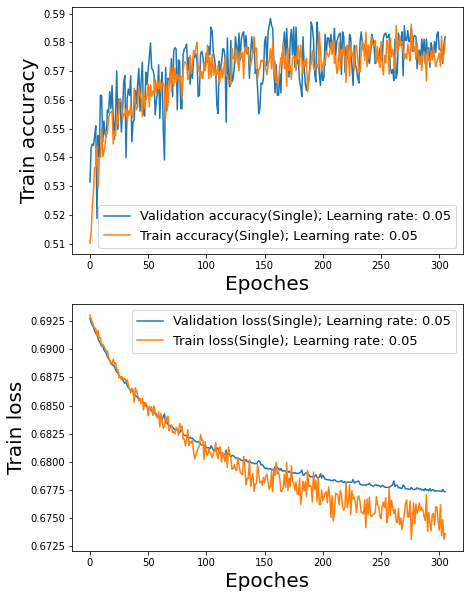

In [0]:
fig = plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.plot(np.arange(best_epoch+patience+1), vali_acc_list,label = 'Validation accuracy(Single); Learning rate: 0.05')
plt.plot(np.arange(best_epoch+patience+1), train_acc, label= 'Train accuracy(Single); Learning rate: 0.05')
plt.xlabel("Epoches", fontsize=20)
plt.ylabel("Train accuracy", fontsize=20)
plt.legend(fontsize=13)

# fig = plt.figure()
plt.subplot(2,1,2)
plt.plot(np.arange(best_epoch+patience+1), vali_loss_list, label = 'Validation loss(Single); Learning rate: 0.05')
plt.plot(np.arange(best_epoch+patience+1), train_loss, label= 'Train loss(Single); Learning rate: 0.05')
plt.xlabel("Epoches", fontsize=20)
plt.ylabel("Train loss", fontsize=20)
plt.legend(fontsize=13)

### Double layer model

In [0]:
def forward(w1, w2, b1, b2, data):
  h = sigmoid((w1.T @ data)+b1)
  output = sigmoid((w2.T @ h)+b2)
  return h, output

In [0]:
def backward(alpha, beta, h, output, w1, w2, b1, b2, data, labels):

  nDim, nData = data.shape
  # Back layer 2
  diff = (labels-output)
  diff_current2 = -(h@diff.T)/nData 

  
  diff_current_b2 = -np.sum(diff, axis = 1)/nData
  diff = np.dot(w2, diff)*h*(1-h) 
  diff_current1 = -data@diff.T/nData
  diff_current_b1 = -np.array([np.sum(diff, axis = 1)]).T/nData

  w2 -= learning_rate*diff_current2
  b2 -= learning_rate*diff_current_b2

  w1 -= learning_rate*diff_current1 
  b1 -= learning_rate*diff_current_b1 

  return w1, w2, b1, b2


In [0]:
  # Calculation
## Initialisation
dim = 100
nDim_train = 2*dim
patience = 100
# Hidden layer
hDim = 128

learning_rate = 0.01
lr = 0.005
epoches = 1000
best_acc = 0
alpha = 1  #1
beta = 1  #0

# Initialise parameter matrix, w, and bias, b
w1 = nn.init.kaiming_uniform_(torch.empty(nDim_train,hDim), mode='fan_in', nonlinearity='relu').numpy()
w2 = nn.init.kaiming_uniform_(torch.empty(hDim, 1), mode='fan_in', nonlinearity='relu').numpy()
b1 = nn.init.kaiming_uniform_(torch.empty(hDim, 1), mode='fan_in', nonlinearity='relu').numpy()
b2 = np.zeros((1,1))

train_loss = []
train_acc = []
vali_acc_list = []
vali_loss_list = []

w1_save_path = save_path+"processed_data/best_logistic_w1_double_layer"
w2_save_path = save_path+"processed_data/best_logistic_w2_double_layer"
b1_save_path = save_path+"processed_data/best_logistic_b1_double_layer"
b2_save_path = save_path+"processed_data/best_logistic_b2_double_layer"

for epoch in range(epoches):
  learning_rate = lr+0.05/np.log(epoch+np.exp(1))
  n_ones = [] 
  n_train_ones = []

  accuracy_train = []
  accuracy_vali = []
  loss_vali = []
  loss_train = []

  for batch_indx, (train_d, labels) in enumerate(train_loader):
    train_d = train_d.numpy().T
    labels = labels.numpy()
   
    h, output = forward(w1, w2, b1, b2, train_d)
    
    w1, w2, b1, b2 = backward(alpha, beta, h, output, w1, w2, b1, b2, train_d, labels)
    acc_train, n_train = acc(output.copy(), labels)
    n_train_ones.append(n_train)
    accuracy_train.append(acc_train)
    loss_train.append(loss(output,labels))
  
  n_train_mean = np.sum(n_train_ones)
  l_train = np.mean(loss_train)
  accuracy_train = np.mean(accuracy_train)

  train_acc.append(accuracy_train)
  train_loss.append(l_train)

  print("Epoch", epoch)
  print("Train loss", l_train)
  print("Train ones", n_train_mean)
  print("Train accuracy", accuracy_train)
  
  for (vali, lab_vali) in vali_loader:
    vali = vali.numpy().T
    lab_vali = lab_vali.numpy()
    _, output_vali_pre = forward(w1, w2, b1, b2, vali)
    acc_vali, n = acc(output_vali_pre.copy(), lab_vali)
    l_vali = loss(output_vali_pre.copy(), lab_vali)

    n_ones.append(n)
    loss_vali.append(l_vali)
    accuracy_vali.append(acc_vali)

  vali_acc = np.mean(accuracy_vali)
  vali_loss = np.mean(loss_vali)

  vali_acc_list.append(vali_acc)
  vali_loss_list.append(vali_loss)

  print("Number of one", np.sum(n_ones))
  print("Vali accuracy", vali_acc)
  print("Vali loss", vali_loss)
  print(10*"-")

  if vali_acc > best_acc:
    best_acc = vali_acc
    best_epoch = epoch

    np.save(w1_save_path, w1)
    np.save(w2_save_path, w2)
    np.save(b1_save_path, b1)
    np.save(b2_save_path, b2)

  if epoch - best_epoch >= patience:
    print("Early stop")
    break

# 负样本过多，导致数据倾向于0，以至于有很高的准确率

Epoch 0
Train loss 1.1253331628506955
Train ones 5508.0
Train accuracy 0.503703076625387
Number of one 909.0
Vali accuracy 0.4970288624787776
Vali loss 0.8959959689970948
----------
Epoch 1
Train loss 0.8389188691408842
Train ones 4925.0
Train accuracy 0.5126439144736842
Number of one 1102.0
Vali accuracy 0.5093378607809848
Vali loss 0.8248527540588504
----------
Epoch 2
Train loss 0.7999978509990244
Train ones 4957.0
Train accuracy 0.5179905185758514
Number of one 1192.0
Vali accuracy 0.5084889643463497
Vali loss 0.7958251941988169
----------
Epoch 3
Train loss 0.7784729520955731
Train ones 4944.0
Train accuracy 0.5191212751547988
Number of one 1186.0
Vali accuracy 0.5093378607809848
Vali loss 0.7787573901732303
----------
Epoch 4
Train loss 0.762647224974139
Train ones 4912.0
Train accuracy 0.519124903250774
Number of one 1519.0
Vali accuracy 0.5335314091680815
Vali loss 0.7696336293585558
----------
Epoch 5
Train loss 0.7547021662115481
Train ones 5050.0
Train accuracy 0.52097281346

In [0]:
best_acc, 

(0.5967741935483871,)

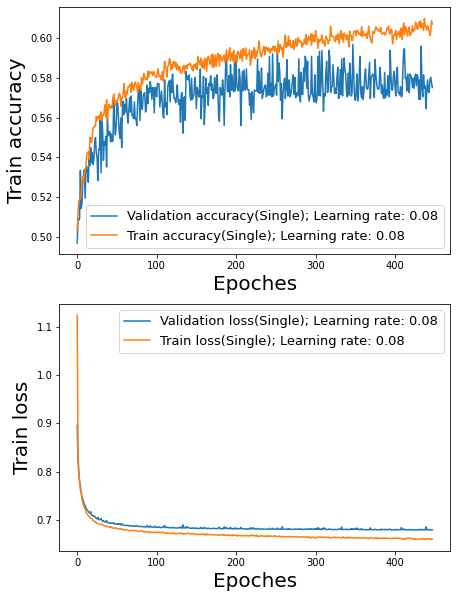

In [0]:
fig = plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.plot(np.arange(best_epoch+patience+1), vali_acc_list,label = 'Validation accuracy(Single); Learning rate: 0.08')
plt.plot(np.arange(best_epoch+patience+1), train_acc, label= 'Train accuracy(Single); Learning rate: 0.08')
plt.xlabel("Epoches", fontsize = 20)
plt.ylabel("Train accuracy", fontsize = 20)
plt.legend(fontsize = 13)

# fig = plt.figure()
plt.subplot(2,1,2)
plt.plot(np.arange(best_epoch+patience+1), vali_loss_list, label = 'Validation loss(Single); Learning rate: 0.08')
plt.plot(np.arange(best_epoch+patience+1), train_loss, label= 'Train loss(Single); Learning rate: 0.08')
plt.xlabel("Epoches",  fontsize = 20)
plt.ylabel("Train loss", fontsize = 20)
plt.legend( fontsize = 13)

## LR & NDCG of logistic regression

In [0]:
# average precision
def average_precision(r):
  score = 0
  for key in r.keys():
    r_docs = r[key].sum()
    if r_docs == 0:
      pass
    else:
      order = np.arange(1, r_docs+1)
      value = (np.array(np.where(r[key] == 1)).squeeze())
      score = score+(order/((value+1)*r_docs)).sum()

  return score/len(r.keys())

In [0]:
def dcg(r_list):
  gain = 2**np.array(r_list)-1
  discount = 1/(np.log2(np.arange(1, len(r_list)+1)+1))
  discount_gain = (gain*discount).sum()
  return discount_gain

In [0]:
def ndcg(r):
  ndcg = []
  for key in r.keys():
    dcg_v = dcg(r[key])
    idcg = dcg(sorted(r[key], reverse=True))
    if idcg == 0:
      pass
    else:
      ndcg.append(dcg_v/idcg)
  return sum(ndcg)/len(r.keys())

In [0]:
# the number of passages of each query
q_len = {}
q_rel = {}
q_pid = {}
for item in qid_vali:
  q_len[item] = np.sum(vali_order["qid"] == item)
  q_rel[item] = list(vali_order.loc[vali_order["qid"] == item]['relevancy'])
  q_pid[item] = list(vali_order.loc[vali_order["qid"] == item]['pid'])

In [0]:
def metric(q_len, q_rel, q_pid, output_vali):
  output_pre = output_vali.copy()
  q_output_pre = {}
  q_pid_sorted = {}
  q_score = {}
  q_rel_sorted = {}
  q_rel_100 = {}
  # q_prob = output_vali.copy()

  # output_pre[output_pre>=0.5] = 1
  # output_pre[output_pre<0.5] = 0
  for item in qid_vali:
    q_output_pre[item] = output_pre[:q_len[item]]
    indx_sort = np.argsort(-np.array(q_output_pre[item]))
    q_output_pre[item] = np.array(q_output_pre[item])[indx_sort]
    q_score[item] = q_output_pre[item].copy()

    q_output_pre[item][q_output_pre[item]>=0.5] = 1
    q_output_pre[item][q_output_pre[item]<0.5] = 0

    q_pid_sorted[item] = np.array(q_pid[item])[indx_sort]
    q_rel_sorted[item] = np.array(q_rel[item])[indx_sort]
    
    if len(q_rel_sorted[item])<100:
      q_rel_100[item] = q_rel_sorted[item]
    else:
      q_rel_100[item] = q_rel_sorted[item][0:100]

    output_pre = output_pre[q_len[item]:]

    if q_len[item]< 100:
      for i in range(q_len[item]):
        file_lr.write(str(item)+ 5*' '+'A1'+5*' '+ str(q_pid_sorted[item][i]).zfill(7)+3*' '+"rank "+str(i+1).zfill(3) + 3*' '+str(round(q_score[item][i], 6))+3*' '+"LR"+"\n")
    else:
      for i in range(100):
        file_lr.write(str(item)+ 5*' '+'A1'+5*' '+ str(q_pid_sorted[item][i]).zfill(7)+3*' '+"rank "+str(i+1).zfill(3) + 3*' '+str(round(q_score[item][i],6))+3*' '+"LR"+"\n")

  print('MAP Top1000:{:.4f}; MAP Top100:{:.4f}; M_NDCG Top1000:{:.4f}; M_NDCG Top100:{:4f}'.format(average_precision(q_rel_sorted), average_precision(q_rel_100), ndcg(q_rel_sorted), ndcg(q_rel_100)))
  return average_precision(q_rel_sorted), average_precision(q_rel_100), ndcg(q_rel_sorted), ndcg(q_rel_100)

**Single layer(if one-layer model is operated, please run this one to calculate metrics)**

In [0]:
file_lr = open('LR.txt', 'w')
w = np.load(w_save_path+".npy")
b = np.load(b_save_path+".npy")
output_vali = list(sigmoid(w.T @ vali_vector.numpy().T+b).squeeze())
metric(q_len, q_rel, q_pid, output_vali)
file_lr.close()

MAP Top1000:0.0163; MAP Top100:0.0139; M_NDCG Top1000:0.1396; M_NDCG Top100:0.043010


**Double layer(if two-layer model is operated, please run this one to calculate metrics)**

In [0]:
w1_save_path = save_path+"processed_data/best_logistic_w1_double_layer"
w2_save_path = save_path+"processed_data/best_logistic_w2_double_layer"
b1_save_path = save_path+"processed_data/best_logistic_b1_double_layer"
b2_save_path = save_path+"processed_data/best_logistic_b2_double_layer"

In [0]:
file_lr = open('LR.txt', 'w')
w1 = np.load(w1_save_path+".npy")
w2 = np.load(w2_save_path+".npy")
b1 = np.load(b1_save_path+".npy")
b2 = np.load(b2_save_path+".npy")
output_vali = list(forward(w1, w2, b1, b2, vali_vector.numpy().T)[1].squeeze())
metric(q_len, q_rel, q_pid, output_vali)
file_lr.close()

MAP Top1000:0.0257; MAP Top100:0.0233; M_NDCG Top1000:0.1552; M_NDCG Top100:0.066645


#---

# XGBoost

## Data clean

In [0]:
import xgboost as xgb

In [0]:
vali_data = pd.read_csv(validation_data_path, sep="\t", engine="python")
train_data = pd.read_csv(train_data_path, sep="\t",engine="python")

In [0]:
"""
Re-order passages based on its qid
"""
# Extract all Qid
qid_all_train = np.unique(train_data.iloc[:, 0].to_numpy())
qid_all_vali = np.unique(vali_data.iloc[:,0].to_numpy())

In [0]:
xgb_train_d = torch.load(save_path+"train_vali_processed/train_data_processed_100d").numpy()
xgb_train_r = torch.load(save_path+"train_vali_processed/train_relevance_processed_100d").numpy()

In [0]:
xgb_vali_d = torch.load(save_path+"train_vali_processed/vali_data_processed_100d").numpy()
xgb_vali_r = torch.load(save_path+"train_vali_processed/vali_relevance_processed_100d").numpy()
xgb_vali_pid = torch.load(save_path+"train_vali_processed/vali_pid_100d").numpy()

In [0]:
lens_all_vali = np.empty(len(qid_all_vali))

for item in range(len(qid_all_vali)):
  data = vali_data.loc[vali_data["qid"]==qid_all_vali[item]]
  lens_all_vali[item] = len(data)

In [0]:
lens_all_train = np.empty(len(qid_all_train))

for item in range(len(qid_all_train)):
  data = train_data.loc[train_data["qid"]==qid_all_train[item]]
  lens_all_train[item] = len(data)

In [0]:
def prediction(n_group, groups_vali, xgb_vali_d):
  # Predict
  lens_start_vali = 0
  pred = np.empty(0)
  for item in range(n_group):
    lens_end_vali = int(lens_start_vali+np.sum(groups_vali[item]))
    xgbTest = xgb.DMatrix(xgb_vali_d[lens_start_vali:lens_end_vali])
    pred = np.hstack((pred, model.predict(xgbTest)))
    lens_start_vali = lens_end_vali

  return pred

In [0]:
def dcg(r_list):  
  gain = 2**np.array(r_list)-1  
  discount = 1/(np.log2(np.arange(1, len(r_list)+1)+1))  
  discount_gain = (gain*discount).sum()  
  return discount_gain

In [0]:
def ndcg(r):  
  ndcg = []  
  for key in r.keys():    
    dcg_v = dcg(r[key])    
    idcg = dcg(sorted(r[key], reverse=True))    
    if idcg == 0:      
      pass    
    else:      
      ndcg.append(dcg_v/idcg)  
  return sum(ndcg)/len(r.keys())

In [0]:
def average_precision(r):
  score = 0
  for key in r.keys():
    r_docs = r[key].sum()
    
    if r_docs == 0:
      pass
    else:
      order = np.arange(1, r_docs+1)
      value = (np.array(np.where(r[key] == 1)).squeeze())
      score = score+(order/((value+1)*r_docs)).sum()
  return score/len(r.keys())

In [0]:
def metric_xgb(qid_all_vali, pred):
  # NDCG
  start = 0
  r={}
  for item in range(len(qid_all_vali)):
    end = int(start+lens_all_vali[item])
    pred_item = pred[start:end]
    pred_indx = np.argsort(-pred_item)

    r[qid_all_vali[item]] = xgb_vali_r[start:end][pred_indx]

    start=end
  return ndcg(r), average_precision(r)

## Model

In [0]:
n_group = 3
groups_vali = np.array_split(lens_all_vali, n_group)
groups_train = np.array_split(lens_all_train, n_group)

###Parameter adjustment(This part is to obtain the optimal parameters)

In [0]:
max_depth = [4, 5, 6, 7, 8, 9, 10, 11, 12]
lr = [0.05, 0.1, 0.2, 0.3]
n_estimators = [50, 100, 200, 300, 500, 1000]
min_child_weight = [0, 1, 2, 3]
subsample = [0.6, 0.7, 0.8, 0.9 ]
colsample_bytree = [0.6, 0.7, 0.8, 0.9]
colsample_level = [0.6, 0.7, 0.8, 0.9]

In [0]:
# The evaluated parameter:
parameter = max_depth

metric = []
for p in parameter:
  print('Parameter value: {}'.format(p))
  model = None
  params = {
    'booster':'gbtree',
    'n_estimators': 50,
    'min_child_weight':1,
    'max_depth': 7,
    'eta': 0.1,    
    'subsample':0.7,   
    "colsample_bytree": 0.7,
    'colsample_bylevel': 0.7,
    'early_stopping_rounds':20,
    'verbose': False,
    'objective':'rank:pairwise',
  }
  lens_start_train = 0

  for i in range(n_group):
    
    lens_end_train = int(lens_start_train+np.sum(groups_train[i]))
    xgb_train = xgb_train_d[lens_start_train:lens_end_train, :]
    targ_train = xgb_train_r[lens_start_train:lens_end_train]
    lens_start_train = lens_end_train
    
    xgbTrain = xgb.DMatrix(xgb_train, label = targ_train)
    xgbTrain.set_group(groups_train[i].astype(int))
    model = xgb.train(params, xgbTrain, num_boost_round=30, xgb_model = model, evals = evalList)

    del xgbTrain
    gc.collect()

  pred = prediction(n_group, groups_vali, xgb_vali_d)
  ndcg_v, ap = metric_xgb(qid_all_vali, pred)
  metric.append([ndcg_v, ap])
  print('NDCG: {:.4f}; Average precision: {:.4f}'.format(ndcg_v, ap))

# np.save(save_path+"processed_data/xgb_parameter_max_depth", np.array(metric))
# np.save(save_path+"processed_data/xgb_parameter_estimators", np.array(metric))
# np.save(save_path+"processed_data/xgb_parameter_lr", np.array(metric))
# np.save(save_path+"processed_data/xgb_parameter_min_child_weight", np.array(metric))
# np.save(save_path+"processed_data/xgb_parameter_subsample", np.array(metric))
# np.save(save_path+"processed_data/xgb_parameter_bytree", np.array(metric))
# np.save(save_path+"processed_data/xgb_parameter_bylevel", np.array(metric))

### Research: train continuation and iteration

**Data split and processing**

In [0]:
metric = []
params = {
  'booster':'gbtree',
  'n_estimators': 50,
  'min_child_weight':1,
  'max_depth': 7,
  'eta': 0.1,    
  'subsample':0.7,   
  "colsample_bytree": 0.7,
  'colsample_bylevel': 0.7,
  'verbose': False,
  'objective':'rank:pairwise',
  'eval_metric':'ndcg'
}

xgbVali = xgb.DMatrix(xgb_vali_d, label = xgb_vali_r)
xgbVali.set_group(lens_all_vali.astype(int))

del vali_data
del train_data
gc.collect()

295

**Model operation**

In [0]:
model = None
n_iteration = 2
for iteration in range(n_iteration):
  print("Iteration {}".format(iteration))
  lens_start_train = 0
  for i in range(n_group):
    print("Group {}".format(i))
    lens_end_train = int(lens_start_train+np.sum(groups_train[i]))
    xgb_train = xgb_train_d[lens_start_train:lens_end_train, :]
    targ_train = xgb_train_r[lens_start_train:lens_end_train]
    lens_start_train = lens_end_train

    xgbTrain = xgb.DMatrix(xgb_train, label = targ_train)
    xgbTrain.set_group(groups_train[i].astype(int))
    
    evalList = [(xgbTrain,'train'),(xgbVali, 'eval')]
    model = xgb.train(params, xgbTrain, num_boost_round=60, xgb_model = model, evals = evalList)
    

  pred = prediction(n_group, groups_vali, xgb_vali_d)
  ndcg_v, ap = metric_xgb(qid_all_vali, pred)
  metric.append([ndcg_v, ap])
  print('NDCG: {:.4f}; Average precision: {:.4f}'.format(ndcg_v, ap))


Iteration 0
Group 0
[0]	train-ndcg:0.146195	eval-ndcg:0.131687
[1]	train-ndcg:0.161379	eval-ndcg:0.133349
[2]	train-ndcg:0.174432	eval-ndcg:0.135093
[3]	train-ndcg:0.177998	eval-ndcg:0.137357
[4]	train-ndcg:0.189537	eval-ndcg:0.140302
[5]	train-ndcg:0.197394	eval-ndcg:0.140177
[6]	train-ndcg:0.203158	eval-ndcg:0.141592
[7]	train-ndcg:0.211263	eval-ndcg:0.142748
[8]	train-ndcg:0.216983	eval-ndcg:0.142481
[9]	train-ndcg:0.226186	eval-ndcg:0.141739
[10]	train-ndcg:0.234999	eval-ndcg:0.141245
[11]	train-ndcg:0.239933	eval-ndcg:0.141721
[12]	train-ndcg:0.244002	eval-ndcg:0.14189
[13]	train-ndcg:0.248243	eval-ndcg:0.142916
[14]	train-ndcg:0.252173	eval-ndcg:0.142925
[15]	train-ndcg:0.260949	eval-ndcg:0.143376
[16]	train-ndcg:0.2648	eval-ndcg:0.142743
[17]	train-ndcg:0.265776	eval-ndcg:0.143245
[18]	train-ndcg:0.273407	eval-ndcg:0.143618
[19]	train-ndcg:0.271722	eval-ndcg:0.142873
[20]	train-ndcg:0.277184	eval-ndcg:0.143457
[21]	train-ndcg:0.2806	eval-ndcg:0.144576
[22]	train-ndcg:0.279909	ev

In [0]:
model.save_model(save_path+'processed_data//LM.model')

In [0]:
model = xgb.Booster()
model.load_model(save_path+'processed_data//LM.model')

**Text file of LM**

In [0]:
def text_file_xgb(qid_all_vali, pred, xbg_vali_pid):
  # NDCG
  start = 0
  r={}
  for item in range(len(qid_all_vali)):
    end = int(start+lens_all_vali[item])
    pred_item = pred[start:end]
    pred_indx = np.argsort(-pred_item)

    r[qid_all_vali[item]] = xgb_vali_r[start:end][pred_indx]
    pid_i = xgb_vali_pid[start:end]
    
    score = pred_item[pred_indx]
    pid = pid_i[pred_indx]
    qid = qid_all_vali[item]

    if len(pid)< 100:
      for i in range(len(pid)):
        file_lm.write(str(qid)+ 5*' '+'A1'+5*' '+ str(pid[i]).zfill(7)+3*' '+"rank "+str(i+1).zfill(3) + 3*' '+str(round(score[i], 6))+3*' '+"LM"+"\n")
    else:
      for i in range(100):
        file_lm.write(str(qid)+ 5*' '+'A1' + 5*' '+str(pid[i]).zfill(7)+3*' '+"rank "+str(i+1).zfill(3) + 3*' '+str(round(score[i],6))+3*' '+"LM"+"\n")

    start=end
  return ndcg(r), average_precision(r)

In [0]:
file_lm = open('LM.txt', 'w')
pred = prediction(n_group, groups_vali, xgb_vali_d)
text_file_xgb(qid_all_vali, pred, xgb_vali_pid)
file_lm.close()

#---

# Neural Network Model

## Forward neural network(pointwise model)

In [0]:
vali_data = pd.read_csv(validation_data_path, sep="\t")
train_data = pd.read_csv(train_data_path, sep="\t")

In [0]:
# extract all QID
qid_train = np.unique(train_data.iloc[:, 0].to_numpy())
qid_vali = np.unique(vali_data.iloc[:, 0].to_numpy())

In [0]:
train_data_order = train_data.loc[train_data["qid"] == qid_train[0]]

for qid in qid_train[1:]:
  text_query = train_data.loc[train_data["qid"] == qid]
  train_data_order = pd.concat((train_data_order, text_query), axis = 0)

In [0]:
vali_data_order = vali_data.loc[vali_data["qid"] == qid_vali[0]]

for qid in qid_vali[1:]:
  text_query = vali_data.loc[vali_data["qid"] == qid]
  vali_data_order = pd.concat((vali_data_order, text_query), axis = 0)

**randomly sampled negative samples and validation data for metrics**

In [0]:
train_order, vali_order = train_data_order.reset_index(), vali_data_order.reset_index()

In [0]:
train_positive = train_order.loc[train_order['relevancy'] == 1.0]
vali_positive = vali_order.loc[vali_order['relevancy']==1.0]
train_negative = train_order.loc[train_order['relevancy'] == 0]
vali_negative = vali_order.loc[vali_order['relevancy']==0]

train_positive_indx = np.array(train_positive.index)
vali_positive_indx = np.array(vali_positive.index)
train_negative_indx = np.array(train_negative.index)
vali_negative_indx = np.array(vali_negative.index)

In [0]:
vali_order.loc[vali_positive_indx].shape

(1208, 6)

In [0]:
# negative sampling: randomly select 1 negative samples from each query
n_sample_up = 2
n_sample_below = 1

train_sampling = train_positive_indx
for qid in qid_train:
  n = np.random.randint(n_sample_below, n_sample_up)
  text_query = train_order.loc[train_order["qid"] == qid]
  text_query = text_query.loc[text_query["relevancy"]==0.0]
  if len(text_query)>0:
    indx = list(np.random.randint(0, len(text_query), size= n))
    train_neg_indx = np.array(text_query.index)[indx]
    train_sampling = np.hstack((train_sampling, train_neg_indx))


In [0]:
# In order to ensure the accuracy and loss of validation data to be feasible, 
# the rate of the positive and the negative is 1:1. Otherwise, the accuracy would 
# be still high if the model randomly predict the relevancy.
vali_sampling = vali_positive_indx
for qid in qid_vali:
  n = np.random.randint(1, 2)#n_sample_up)
  text_query = vali_order.loc[vali_order["qid"] == qid]
  text_query = text_query.loc[text_query["relevancy"]==0.0]

  if len(text_query)>0:
    indx = list(np.random.randint(0, len(text_query), size= n))
    vali_neg_indx = np.array(text_query.index)[indx]
    vali_sampling = np.hstack((vali_sampling, vali_neg_indx))

**Prepare the dataset for model**

In [0]:
train_vector = torch.load(save_path+"train_vali_processed/train_data_processed_100d")
train_relevance = torch.load(save_path+"train_vali_processed/train_relevance_processed_100d")

In [0]:
vali_vector = torch.load(save_path+"train_vali_processed/vali_data_processed_100d")
vali_relevance = torch.load(save_path+"train_vali_processed/vali_relevance_processed_100d")
vali_relevance = vali_relevance.numpy()

In [0]:
train_sampling_vector = train_vector[train_sampling]
train_sampling_r = train_relevance[train_sampling]
vali_sampling_vector = vali_vector[vali_sampling]
vali_sampling_r = vali_relevance[vali_sampling]

In [0]:
torch.sum(train_sampling_r), vali_sampling_r.sum()

(tensor(4797.), tensor(1208.))

In [0]:
train_set = torch.utils.data.TensorDataset(train_sampling_vector, train_sampling_r)
vali_set = torch.utils.data.TensorDataset(vali_vector)

In [0]:
batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
vali_loader = DataLoader(vali_set, batch_size=len(vali_set), shuffle=False, pin_memory=True, num_workers=0)

In [0]:
lens_all_vali = np.empty(len(qid_vali))

for item in range(len(qid_vali)):
  data = vali_data.loc[vali_data["qid"]==qid_vali[item]]
  lens_all_vali[item] = len(data)

In [0]:
class classifier(nn.Module):
  def __init__(self, hidden_1, dim):
    super(classifier, self).__init__()

    self.fc1 = nn.Linear(2*dim, hidden_1)
    self.fc2 = nn.Linear(hidden_1, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_):
    output = self.sigmoid(self.fc1(input_))
    output = self.sigmoid(self.fc2(output))
    return output


In [0]:
def acc(labels_pre, labels):
  labels_pre[labels_pre>=0.5] = 1
  labels_pre[labels_pre<0.5] = 0
  
  return torch.sum(labels == labels_pre.squeeze()).item()/len(labels)


In [0]:
def dcg(r_list):
  gain = 2**np.array(r_list)-1
  discount = 1/(np.log2(np.arange(1, len(r_list)+1)+1))
  discount_gain = (gain*discount).sum()
  return discount_gain

In [0]:
def ndcg(r):
  ndcg = []
  for key in r.keys():
    dcg_v = dcg(r[key])
    idcg = dcg(sorted(r[key], reverse=True))
    if idcg == 0:
      pass
    else:
      ndcg.append(dcg_v/idcg)
  return sum(ndcg)/len(r.keys())

In [0]:
def average_precision(r):
  score = 0
  for key in r.keys():
    r_docs = r[key].sum()
    
    if r_docs == 0:
      pass
    else:
      order = np.arange(1, r_docs+1)
      value = (np.array(np.where(r[key] == 1)).squeeze())
      score = score+(order/((value+1)*r_docs)).sum()
  return score/len(r.keys())

In [0]:
def NDCG_lr(pred_vali, rank_vali_r, qid_s, lens_all):
  pred_vali = pred_vali.data.cpu().numpy().squeeze()
  start = 0
  r = {}
  for i in range(len(qid_s)):
    
    lens = lens_all[i]
    end = int(start+lens)

    pred_vali_i = pred_vali[start:end]
    pred_indx = np.argsort(-pred_vali_i)

    r[qid_s[i]] = rank_vali_r[start:end][pred_indx]
    start = end

  return ndcg(r), average_precision(r)

In [0]:
hidden = 64
dim = 100
learning_rate = 0.01
model = classifier(hidden, dim)
model = model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [0]:
epoches = 200
train_loss = []
train_acc = []

best_epoch = 0
patience = 20
score = []
best_ndcg = 0
best_map = 0

for epoch in range(epoches):
  output_ones = 0
  output_acc = 0
  n_ones = [] 
  n_train_ones = []

  accuracy_train = []
  accuracy_vali = []
  loss_vali = []
  loss_train = []
  model.train()
  for batch_indx, (train_data, indx) in enumerate(train_loader):
    # print(batch_indx)
    train_data, indx = train_data.cuda(), indx.cuda()
    optimizer.zero_grad()

    output = model(train_data)
    output = output.squeeze()
    loss = criterion(output, indx)
    loss.backward()
    optimizer.step()
    # break
    t_acc = acc(output, indx)
    output_acc+=t_acc
  # break   
  print("Train accuracy:{}".format((output_acc)/(batch_indx+1)))
  model.eval()
  with torch.no_grad():
    for (vali_d, labels_vali) in vali_loader:
      vali_d, labels_vali = vali_d.cuda(), labels_vali.cuda()
      output_vali_pre = model(vali_d)
      output_vali_pre = output_vali_pre.squeeze()
      acc_vali = acc(output_vali_pre, labels_vali)
      l_vali = criterion(output_vali_pre, labels_vali).item()

      loss_vali.append(l_vali)
      accuracy_vali.append(acc_vali)

    vali_acc = np.mean(accuracy_vali)
    vali_loss = np.mean(loss_vali)

    print("Validation Accuracy", vali_acc)
    print("Validation Loss", vali_loss)

    score_ndcg, score_map = NDCG_lr(output_vali_pre, vali_relevance, qid_vali, lens_all_vali)
    score.append([score_ndcg, score_map])
    print("NDCG:{:.4f}; MAP:{:.4f}".format(score_ndcg, score_map))
    print(10*"-")

    if score_ndcg > best_ndcg:
      best_ndcg = score_ndcg
      best_map = score_map
      best_epoch = epoch
      torch.save(model.state_dict(), save_path+"processed_data/best_LR_pytorch")
    if epoch - best_epoch > patience:
      break


Train accuracy:0.5642525337837838
Validation Accuracy 0.5275253186877346
Validation Loss 13.054959297180176
NDCG:0.1368; MAP:0.0147
----------
Train accuracy:0.5655653815580286
Validation Accuracy 0.6944051842228607
Validation Loss 8.443897247314453
NDCG:0.1417; MAP:0.0202
----------
Train accuracy:0.5768692865659777
Validation Accuracy 0.39603948727107563
Validation Loss 16.688045501708984
NDCG:0.1377; MAP:0.0151
----------
Train accuracy:0.5803482710651828
Validation Accuracy 0.4847099694571089
Validation Loss 14.237990379333496
NDCG:0.1403; MAP:0.0169
----------
Train accuracy:0.5777176073131955
Validation Accuracy 0.3505206978175749
Validation Loss 17.945777893066406
NDCG:0.1375; MAP:0.0155
----------
Train accuracy:0.5824088334658188
Validation Accuracy 0.40929377837048375
Validation Loss 16.321815490722656
NDCG:0.1375; MAP:0.0144
----------
Train accuracy:0.5943995926073132
Validation Accuracy 0.37902195661259486
Validation Loss 17.15825843811035
NDCG:0.1387; MAP:0.0162
---------

In [0]:
score = np.array(score)
score[int(np.array(np.where(score == score[:,0].max()))[0]),:]

array([0.15069876, 0.02331044])

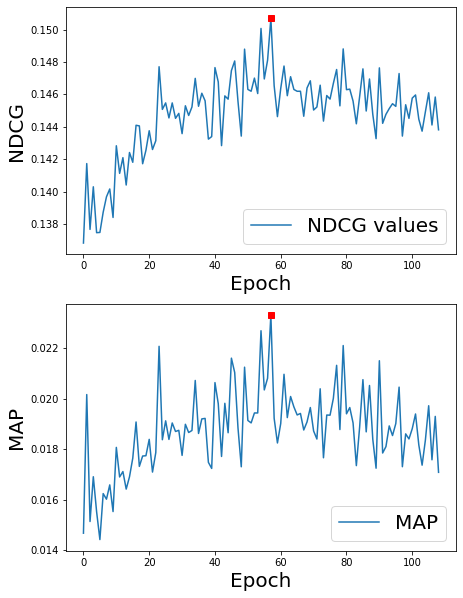

In [0]:
fig = plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
max_indx = np.argmax(score[:, 0])
plt.plot(np.arange(len(score)), score[:, 0], label = 'NDCG values')
plt.plot(max_indx, np.max(score[:, 0]), 'rs')
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("NDCG", fontsize=20)
plt.legend(fontsize=20)

# fig = plt.figure()
plt.subplot(2,1,2)
plt.plot(np.arange(len(score)), score[:, 1], label = 'MAP')
max_indx = np.argmax(score[:, 1])
plt.plot(max_indx, np.max(score[:, 1]), 'rs')
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("MAP", fontsize=20)
plt.legend(fontsize=20)

## RankNet(pairwise model)

### Data collection

In [0]:
vali_data = pd.read_csv(validation_data_path, sep="\t", engine="python")
train_data = pd.read_csv(train_data_path, sep="\t",engine="python")

In [0]:
vali_vector = torch.load(save_path+"train_vali_processed/vali_data_processed_100d")
vali_relevance = torch.load(save_path+"train_vali_processed/vali_relevance_processed_100d").numpy()

In [0]:
rank_vali_pid = torch.load(save_path+"train_vali_processed/vali_pid_100d")

In [0]:
# Extract all Qid
qid_train = np.unique(train_data.iloc[:, 0].to_numpy())
qid_vali = np.unique(vali_data.iloc[:,0].to_numpy())

In [0]:
lens_all_vali = np.empty(len(qid_vali))

for item in range(len(qid_vali)):
  data = vali_data.loc[vali_data["qid"]==qid_vali[item]]
  lens_all_vali[item] = len(data)

In [0]:
lens_all_train = np.empty(len(qid_train))

for item in range(len(qid_train)):
  data = train_data.loc[train_data["qid"]==qid_train[item]]
  lens_all_train[item] = len(data)

In [0]:
n_group = 15
groups_vali = np.array_split(lens_all_vali, n_group)
groups_train = np.array_split(lens_all_train, n_group)

###paired dataset(Processed and saved, no need to run if the link works)

In [0]:
train_vector = torch.load(save_path+"train_vali_processed/train_data_processed_100d").numpy()
train_relevance = torch.load(save_path+"train_vali_processed/train_relevance_processed_100d").numpy()

In [0]:
def pair_data(lens_start, lens_part, rank_d, rank_r):

  x_i = []#np.empty(0)
  x_j = []#np.empty(0)
  pairs = []
  for item in np.array(lens_part.astype(int)):
    lens_end = int(lens_start+item)
    rank_ = rank_d[lens_start:lens_end, :]
    targ_ = rank_r[lens_start:lens_end]
    lens_start = lens_end

    for i in range(item-1):
      for j in range(i+1, item):
        if targ_[i] > targ_[j]:
          pairs.append([i,j])
          x_i.append(rank_[i])
          x_j.append(rank_[j])

        elif targ_[j] > targ_[i]:
          pairs.append([j,i])
          x_i.append(rank_[j])
          x_j.append(rank_[i])
  rank_x_i = torch.tensor(x_i)
  rank_x_j = torch.tensor(x_j)
  pairs = torch.tensor(pairs).float()
  return rank_x_i, rank_x_j, lens_start, pairs

data_i, data_j, _, _ = pair_data(0, lens_all_train, train_vector, train_relevance)
torch.save(data_i, save_path+"train_vali_processed/data_i_ranknet")
torch.save(data_j, save_path+'train_vali_processed/data_j_ranknet')

###Model

In [0]:
class RankNet_dataset(Dataset):
  '''
  batch size: 所有query
  n_groups: 1000
  '''
  def __init__(self, all_data_i, all_data_j):

    self.all_data_i = all_data_i
    self.all_data_j = all_data_j

  def __getitem__(self, indx):
    data_i = self.all_data_i[indx]
    data_j = self.all_data_j[indx]
    return data_i, data_j

  def __len__(self):
    return len(all_data_i)
      

In [0]:
all_data_i = torch.load(save_path+"train_vali_processed/data_i_ranknet")
all_data_j = torch.load(save_path+'train_vali_processed/data_j_ranknet')

dataset_train = RankNet_dataset(all_data_i, all_data_j)
num_data = len(dataset_train)
idx = list(range(num_data))
train_set = Subset(dataset_train, idx)
vali_set = vali_vector

In [0]:
batch_size = 65536
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)

In [0]:
batch_size = 1024
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False, pin_memory=True)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class RankNet(nn.Module):
  def __init__(self, inputs, hidden_size, outputs):
    super(RankNet, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(inputs, hidden_size),
        nn.ReLU(inplace = True),
        nn.Linear(hidden_size, outputs)
    )
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, data_i, data_j):
    s_1 = self.model(data_i)
    s_2 = self.model(data_j)
    output = self.sigmoid(s_1-s_2)
    return output

  def predict(self, vali_data):
    return self.model(vali_data)

In [0]:
def dcg(r_list):
  gain = 2**np.array(r_list)-1
  discount = 1/(np.log2(np.arange(1, len(r_list)+1)+1))
  discount_gain = (gain*discount).sum()
  return discount_gain

In [0]:
def ndcg(r):
  ndcg = []
  for key in r.keys():
    dcg_v = dcg(r[key])
    idcg = dcg(sorted(r[key], reverse=True))
    if idcg == 0:
      pass
    else:
      ndcg.append(dcg_v/idcg)
  return sum(ndcg)/len(r.keys())

In [0]:
def average_precision(r):
  score = 0
  for key in r.keys():
    r_docs = r[key].sum()
    
    if r_docs == 0:
      pass
    else:
      order = np.arange(1, r_docs+1)
      value = (np.array(np.where(r[key] == 1)).squeeze())
      score = score+(order/((value+1)*r_docs)).sum()
  return score/len(r.keys())

In [0]:
def NDCG_RankNet(pred_vali, rank_vali_r, qid_s, lens_all):
  pred_vali = pred_vali.data.cpu().numpy()
  start = 0
  r = {}
  for i in range(len(qid_s)):
    
    lens = lens_all[i]
    end = int(start+lens)

    pred_vali_i = pred_vali[start:end]
    pred_indx = np.argsort(-pred_vali_i)

    r[qid_s[i]] = rank_vali_r[start:end][pred_indx]
    start = end
  return ndcg(r), average_precision(r)

In [0]:
inpDim = 200
hidden_size = 64
outDim = 1
learning_rate = 0.0005
model = RankNet(inpDim, hidden_size, outDim)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model = model.to(device)

In [0]:
epoches = 100
best_ndcg = 0
best_map = 0
best_epoch = 0
patience = 10
score = []
for epoch in range(epoches):
  print('Epoch: {}'.format(epoch))
  pred_vali = torch.empty(0).to(device)
  pairs_lens = torch.empty(0)

  model.train()
  for batch_indx, (data_i, data_j) in enumerate(train_loader):
    nData, nDim = data_i.shape
    labels = torch.ones(nData)
    data_i, data_j, labels = data_i.to(device), data_j.to(device), labels.to(device)
    optimizer.zero_grad()
    pred = model(data_i, data_j)
    loss = criterion(pred.squeeze(), labels)
    loss.backward()
    optimizer.step()
    if batch_indx%50 == 0:
      print("Batch: {}; Loss:{:.4f}".format(batch_indx, loss))  
    
  model.eval()
  with torch.no_grad():
    for batch_indx, validation_data in enumerate(vali_loader):
      validation_data = validation_data.to(device)
      output_vali = model.predict(validation_data)
      pred_vali = torch.cat((pred_vali, output_vali.squeeze()), 0)
    score_ndcg, score_map = NDCG_RankNet(pred_vali, vali_relevance, qid_vali, lens_all_vali)
    score.append([score_ndcg, score_map])
    print("NDCG:{:.4f}; MAP:{:.4f}".format(score_ndcg, score_map))
    if score_ndcg > best_ndcg:
      best_ndcg = score_ndcg
      best_map = score_map
      best_epoch = epoch
      torch.save(model.state_dict(), save_path+"processed_data/best_RankNet_pytorch")
    if epoch - best_epoch > patience:
      break
    

    

Epoch: 0
Batch: 0; Loss:0.6932
Batch: 50; Loss:0.6581
NDCG:0.1423; MAP:0.0181
Epoch: 1
Batch: 0; Loss:0.6445
Batch: 50; Loss:0.6101
NDCG:0.1503; MAP:0.0240
Epoch: 2
Batch: 0; Loss:0.5978
Batch: 50; Loss:0.5677
NDCG:0.1547; MAP:0.0251
Epoch: 3
Batch: 0; Loss:0.5534
Batch: 50; Loss:0.5219
NDCG:0.1604; MAP:0.0287
Epoch: 4
Batch: 0; Loss:0.5127
Batch: 50; Loss:0.4836
NDCG:0.1639; MAP:0.0304
Epoch: 5
Batch: 0; Loss:0.4716
Batch: 50; Loss:0.4471
NDCG:0.1667; MAP:0.0320
Epoch: 6
Batch: 0; Loss:0.4388
Batch: 50; Loss:0.4167
NDCG:0.1692; MAP:0.0336
Epoch: 7
Batch: 0; Loss:0.4058
Batch: 50; Loss:0.3860
NDCG:0.1713; MAP:0.0355
Epoch: 8
Batch: 0; Loss:0.3771
Batch: 50; Loss:0.3593
NDCG:0.1727; MAP:0.0365
Epoch: 9
Batch: 0; Loss:0.3523
Batch: 50; Loss:0.3378
NDCG:0.1730; MAP:0.0364
Epoch: 10
Batch: 0; Loss:0.3313
Batch: 50; Loss:0.3161
NDCG:0.1726; MAP:0.0355
Epoch: 11
Batch: 0; Loss:0.3089
Batch: 50; Loss:0.2985
NDCG:0.1732; MAP:0.0360
Epoch: 12
Batch: 0; Loss:0.2936
Batch: 50; Loss:0.2795
NDCG:0.

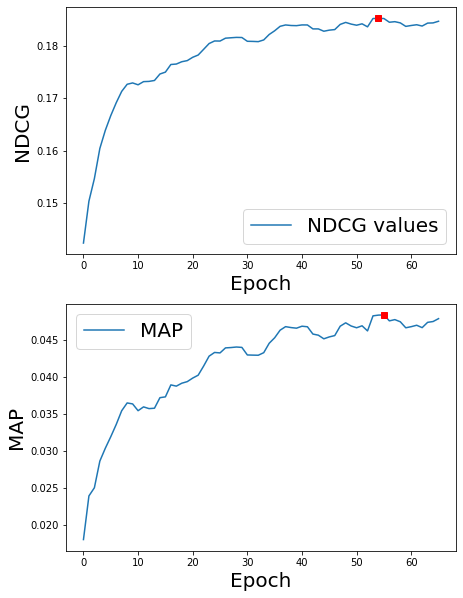

In [0]:
score = np.array(score)
fig = plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
max_indx = np.argmax(score[:, 0])
plt.plot(np.arange(len(score)), score[:, 0], label = 'NDCG values')
plt.plot(max_indx, np.max(score[:, 0]), 'rs')
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("NDCG", fontsize=20)
plt.legend(fontsize=20)

# fig = plt.figure()
plt.subplot(2,1,2)
plt.plot(np.arange(len(score)), score[:, 1], label = 'MAP')
max_indx = np.argmax(score[:, 1])
plt.plot(max_indx, np.max(score[:, 1]), 'rs')
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("MAP", fontsize=20)
plt.legend(fontsize=20)

In [0]:
score[int(np.array(np.where(score == score[:,0].max()))[0]),:]

array([0.18530773, 0.04838875])

**Text file**

In [0]:
#@title
model.load_state_dict(torch.load(save_path+"processed_data/best_RankNet_pytorch"))
model.eval()
with torch.no_grad():
  for batch_indx, validation_data in enumerate(vali_loader):
    validation_data = validation_data.to(device)
    output_vali = model.predict(validation_data)
    pred_vali = torch.cat((pred_vali, output_vali.squeeze()), 0)

In [0]:
def text_file(pred_vali, rank_vali_r, qid_s, lens_all, rank_vali_pid):
  pred_vali = pred_vali.data.cpu().numpy()
  rank_vali_pid = rank_vali_pid.numpy()
  start = 0
  r = {}
  for i in range(len(qid_s)):
    
    lens = lens_all[i]
    end = int(start+lens)

    pred_vali_i = pred_vali[start:end]
    pid_i = rank_vali_pid[start:end]

    pred_indx = np.argsort(-pred_vali_i)
    score = pred_vali_i[pred_indx]
    pid = pid_i[pred_indx]
    qid = qid_s[i]

    if len(pid)< 100:
      for item in range(len(pid)):
        file_NN.write(str(qid)+ 5*' '+'A1'+5*' '+ str(pid[item]).zfill(7)+3*' '+"rank "+str(item+1).zfill(3) + 3*' '+str(round(score[item], 6))+3*' '+"NN"+"\n")
    else:
      for item in range(100):
        file_NN.write(str(qid)+ 5*' '+'A1' + 5*' '+str(pid[item]).zfill(7)+3*' '+"rank "+str(item+1).zfill(3) + 3*' '+str(round(score[item],6))+3*' '+"NN"+"\n")

    start = end


In [0]:
file_NN = open('NN.txt', 'w')
text_file(pred_vali, vali_relevance, qid_vali, lens_all_vali, rank_vali_pid)
file_NN.close()